In [1]:
# Cleaning
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates
import datetime as dt


# Modelling
from scipy.stats import boxcox
import sklearn.preprocessing as sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [2]:
df = pd.read_excel("Data/midterm_project_cleaned.xlsx")

In [3]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

# Data description

In [4]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,price,renovated,basement,decade,geo1,geo2,avg_price_by_zipcode
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,221900,False,False,Category B,centre,west,310612.76
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,538000,True,True,Category B,north,west,469928.77
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,180000,False,False,Category B,north,west,462488.87
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,604000,False,True,Category C,centre,west,551768.52
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,510000,False,False,Category C,north,centre,685675.84


In [5]:
df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'renovated', 'basement',
       'decade', 'geo1', 'geo2', 'avg_price_by_zipcode'],
      dtype='object')

# Rearranging columns

In [6]:
# Drop the "renovated" column from the cleaned dataframe
# We assume that a house is "renovated" if the renovation took place in the last 10 years or 
# the house is not older than 10 years (and doesn't require renovation yet)

conditions = [(df["yr_renovated"] > 2004), (df['yr_built'] > 2004)]
values = [1, 1]
df['renovated_or_new'] = np.select(conditions, values)

# Dropping column yr_renovated
df.drop(["yr_renovated"], axis = 1, inplace=True)

In [7]:
# And renovated

df.drop(["renovated"], axis = 1, inplace=True)

In [8]:
# Dropping column yr_built 

df.drop(["yr_built"], axis=1, inplace=True)

# and renaming column decade for more clarity

decade_dict = {"Category A": "1900-1929", "Category B": "1930-1959", "Category C": "1960-1989", "Category D": "1990-2015"}
df = df.replace({"decade": decade_dict})

In [9]:
# Sqft_living = sqft_above + sqft_basement? 

high_corr = df.sqft_living == df.sqft_above + df.sqft_basement
high_corr.value_counts()

True    21596
dtype: int64

In [10]:
# Dropping sqft_above

df.drop(["sqft_above"], axis = 1, inplace=True)

In [11]:
# Dropping basement

df.drop(["basement"], axis = 1, inplace=True)

# EDA

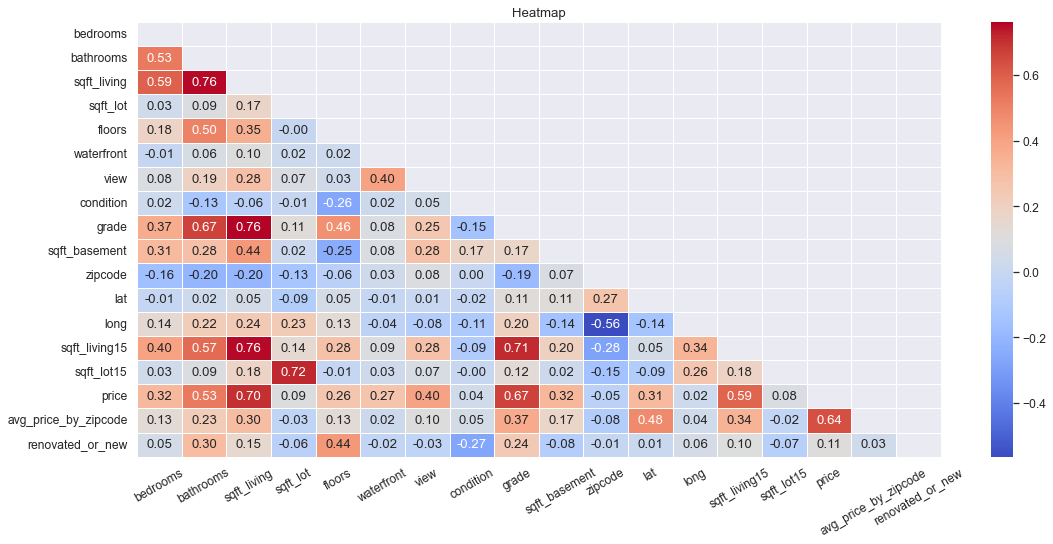

In [12]:
# Heatmap

correlation_matrix = df.corr()
sns.set(font_scale=1.1) # Font size
        
fig, ax = plt.subplots(figsize = (18,8))

ax.set_title("Heatmap")
corr = df.corr()

matrix = np.triu(corr) # Getting the Upper Triangle of the corelation matrix
sns.heatmap(corr, cmap = "coolwarm", linewidth = 1, annot=True,  fmt = ".2f", mask=matrix) # using the upper triangle matrix as mask 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30) # Rotates labels on x axis

plt.show()

There are no columns with correlation > 0.8: no additional columns have to be dropped because of high correlation

Interpretation of correlations > 0.7: 

- sqft_living/bathrooms: self-explanatory: big houses have more bathrooms, small houses less bathrooms
- sqft_living/sqft_living_15: houses of similar size are usually grouped next to each other
- sqft_lot/sqft_lot_15: houses with lots of similar size are usually grouped next to each other
- sqft_living/grade: quality level of construction and design is correlated with the size of the house
- sqft_livng15/grade: quality level of construction and design is correlated with the size of the houses in the area

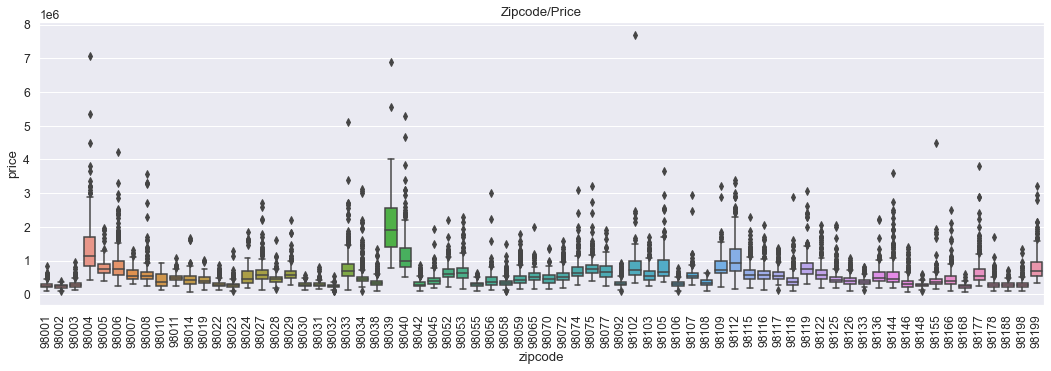

In [13]:
# The heatmap show that the price is significantly correlated with the size of the house
# and houses of similar sizes are grouped next to each other; boxplot shows that in some 
# areas (zipcodes) expensive houses are concentrated

fig, axe = plt.subplots(figsize = (18,5.2))
axe.set_title("Zipcode/Price")
sns.boxplot(data = df, x = "zipcode", y = "price")
axe.set_xticklabels(axe.get_xticklabels(),rotation=90)
plt.show()

In [14]:
# Introducing geographical factor due to the concentration of expensive houses in specific areas: 
# average price by zip_code

df['avg_price_by_zipcode'] = round(df.groupby(['zipcode'])['price'].transform('mean'),2)

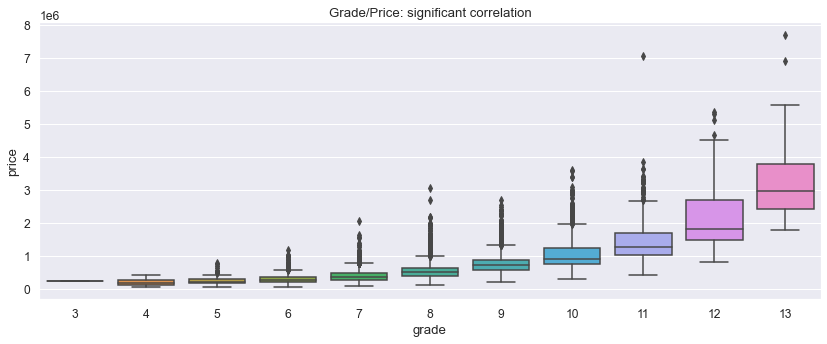

In [15]:
# Heatmap shows significant correlation between price and grade: detailed view on a boxplot

fig, axe = plt.subplots(figsize = (14,5.1))
axe.set_title("Grade/Price: significant correlation")
sns.boxplot(data = df, x = "grade", y = "price",)
plt.show()

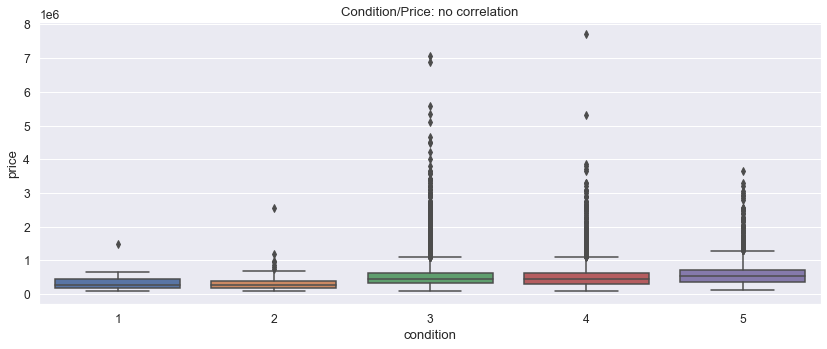

In [16]:
# Heatmap shows almost no correlation between price and condition

fig, axe = plt.subplots(figsize = (14,5.2))
axe.set_title("Condition/Price: no correlation")
sns.boxplot(data = df, x = "condition", y = "price",)
plt.show()

In [17]:
# Dropping column "condition" due to the lack of correlation between price and condition

df.drop(["condition"], axis = 1, inplace=True)

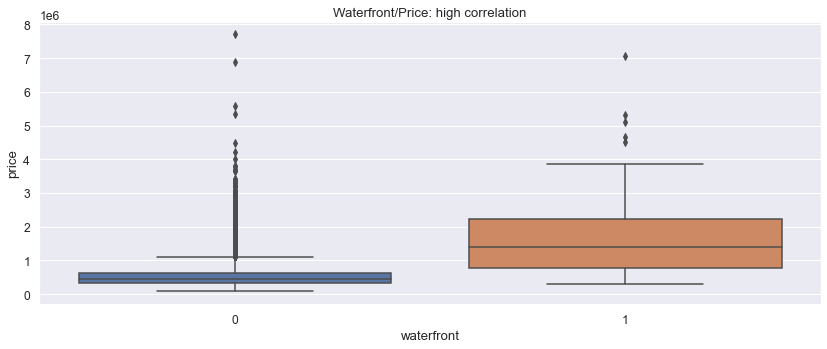

In [18]:
# Correlation between price and waterfront is high

fig, axe = plt.subplots(figsize = (14,5.2))
axe.set_title("Waterfront/Price: high correlation")
sns.boxplot(data = df, x = "waterfront", y = "price",)
plt.show()

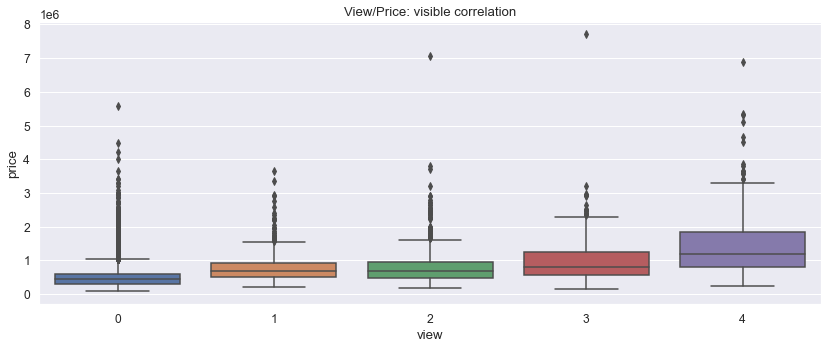

In [19]:
# Correlation between price and view is less clear but also visible

fig, axe = plt.subplots(figsize = (14,5.2))
axe.set_title("View/Price: visible correlation")
sns.boxplot(data = df, x = "view", y = "price",)
plt.show()

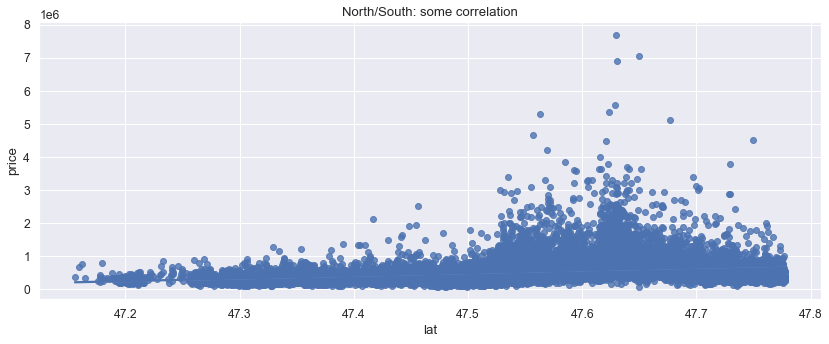

In [20]:
# Latitude and longitude: the heatmap shows some correlation between price and latitude

fig3, axe3 = plt.subplots(figsize = (14,5.1))
axe3.set_title("North/South: some correlation")

sns.set_style("whitegrid")
sns.regplot(x="lat", y="price", data=df)
plt.show()

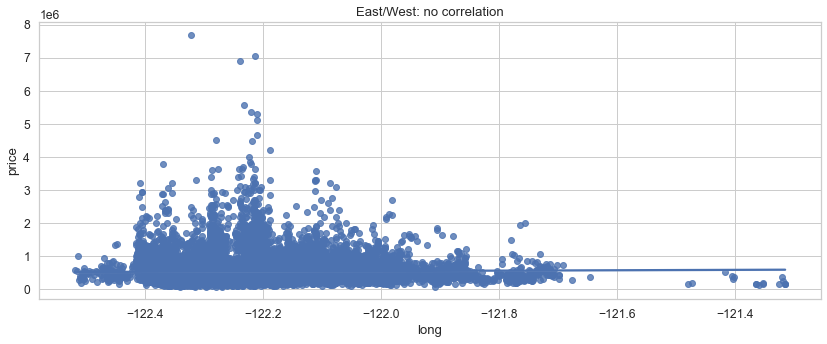

In [21]:
# But there is no corelation between price and longitude:

fig4, axe4 = plt.subplots(figsize = (14,5.1))
axe4.set_title("East/West: no correlation")

sns.set_style("whitegrid")
sns.regplot(x="long", y="price", data=df)
plt.show()

In [22]:
# Price is to some degree corelated to the north/south axis but it's not corelated to the east/west axis: 
# dropping column "long"

df.drop(["long"], axis = 1, inplace=True)

# Distribution

<AxesSubplot:xlabel='sqft_lot15', ylabel='Count'>

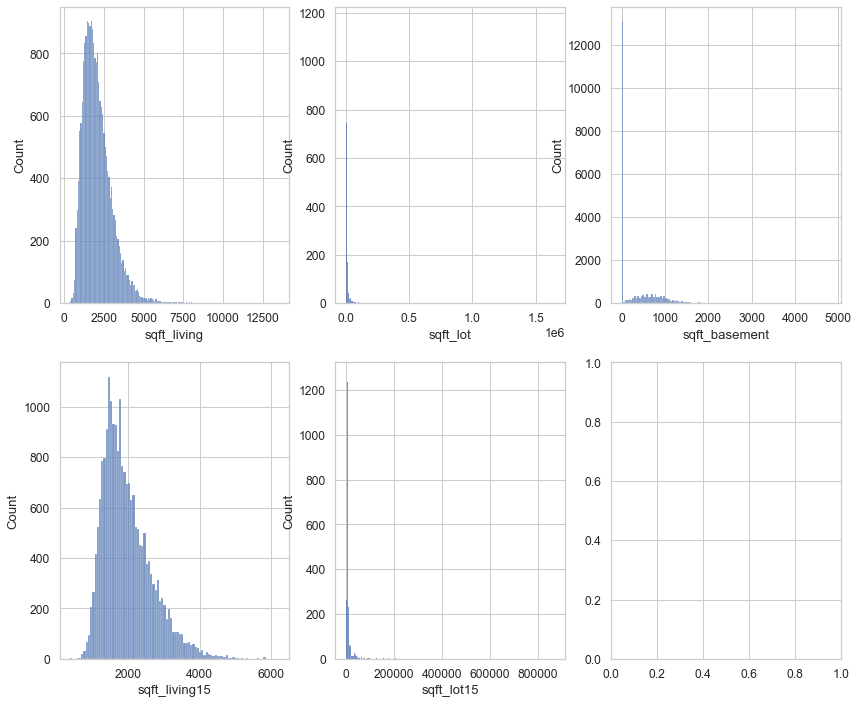

In [23]:
fig, axe = plt.subplots(2,3,figsize = (14,12))

sns.histplot(df, x=df.loc[:, "sqft_living"], ax = axe[0,0]) 
sns.histplot(df, x=df.loc[:, "sqft_lot"], ax = axe [0,1])
sns.histplot(df, x=df.loc[:, "sqft_basement"], ax = axe [0,2])
sns.histplot(df, x=df.loc[:, "sqft_living15"], ax = axe [1,0])
sns.histplot(df, x=df.loc[:, "sqft_lot15"], ax = axe [1,1])

# Modelling

In [24]:
# X/y split
X = df.drop("price", axis=1)
y = df["price"]

In [25]:
# Train/test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [26]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_basement', 'zipcode', 'lat',
       'sqft_living15', 'sqft_lot15', 'decade', 'geo1', 'geo2',
       'avg_price_by_zipcode', 'renovated_or_new'],
      dtype='object')

In [27]:
# Splitting into X_train_num, X_train_cat, X_test_num, X_test_cat

X_train_num = X_train[["sqft_living", "sqft_basement", "sqft_lot", "sqft_living15"]]
X_train_cat = X_train[["bedrooms", "bathrooms", "floors", "waterfront", "view", "grade", "avg_price_by_zipcode", "lat", "renovated_or_new", "decade"]]

X_test_num = X_test[["sqft_living", "sqft_basement", "sqft_lot", "sqft_living15"]]
X_test_cat = X_test[["bedrooms", "bathrooms", "floors", "waterfront", "view", "grade", "avg_price_by_zipcode", "lat", "renovated_or_new", "decade"]]

In [28]:
# Applying standard scaler to X_train_num, X_test_num (scaling)



# Fitting on X_train_num
scaler = MinMaxScaler() 
scaler.fit(X_train_num)

# Transforming X_train num and X_test_num
X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)

In [29]:
# Splitting categorical columns into nominal and categorical ones

X_train_cat_nom = X_train_cat["decade"]
X_test_cat_nom = X_test_cat["decade"]

X_train_cat_ord = X_train_cat[["bedrooms", "bathrooms", "floors", "waterfront", "view", "grade", "avg_price_by_zipcode", "lat", "renovated_or_new"]]
X_test_cat_ord = X_test_cat[["bedrooms", "bathrooms", "floors", "waterfront", "view", "grade", "avg_price_by_zipcode", "lat", "renovated_or_new"]]


In [30]:
# Hot encoding nominal columns

X_train_cat_nom_encoded = pd.get_dummies(X_train_cat_nom, drop_first = True)
X_test_cat_nom_encoded = pd.get_dummies(X_test_cat_nom, drop_first = True)

In [31]:
# Reseting indexes before concatenating

X_train_cat_nom_encoded.reset_index(drop=True, inplace=True)
X_test_cat_nom_encoded.reset_index(drop=True, inplace=True)
X_train_cat_ord.reset_index(drop=True, inplace=True)
X_test_cat_ord.reset_index(drop=True, inplace=True)

In [32]:
# Concatenating nominal and ordinal

X_train_cat_ready = pd.concat([X_train_cat_nom_encoded, X_train_cat_ord], axis = 1)
X_test_cat_ready = pd.concat([X_test_cat_nom_encoded, X_test_cat_ord], axis = 1)

In [33]:
# Concatenating X_train and X_test dataframes

X_train_num_scaled.reset_index(drop=True, inplace=True)
X_train_cat.reset_index(drop=True, inplace = True)
X_test_num_scaled.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace = True)


X_train_ready = pd.concat([X_train_num_scaled, X_train_cat_ready], axis = 1)
X_test_ready = pd.concat([X_test_num_scaled, X_test_cat_ready], axis = 1)

In [34]:
# Linear regression

model=LinearRegression()    
model.fit(X_train_ready, y_train) 

LinearRegression()

# Model score

In [35]:
model.score(X_test_ready, y_test)

0.7694143699124504

In [36]:
# Running prediction on X_train_ready to compare model score with the one from X_test_ready

model.score(X_train_ready, y_train)

0.7938394249168395

In [37]:
y_pred=model.predict(X_test_ready)   

In [38]:
R2=r2_score(y_test,y_pred)
R2

0.7694143699124504

In [39]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test_ready.shape[1]-1)
Adj_R2

0.7688434367522212

# Error metrics

In [40]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
RMSE = mse(y_test, y_pred, squared=False)
print(RMSE)

32025187368.556957
104155.24154064702
178955.82518755


In [41]:
y_pred_train = model.predict(X_train_ready)   
print(mse(y_train, y_pred_train))
print(mae(y_train, y_pred_train))
RMSE_train = mse(y_train, y_pred_train, squared=False)
print(RMSE_train)

27475199355.525585
101229.65097562585
165756.445894347


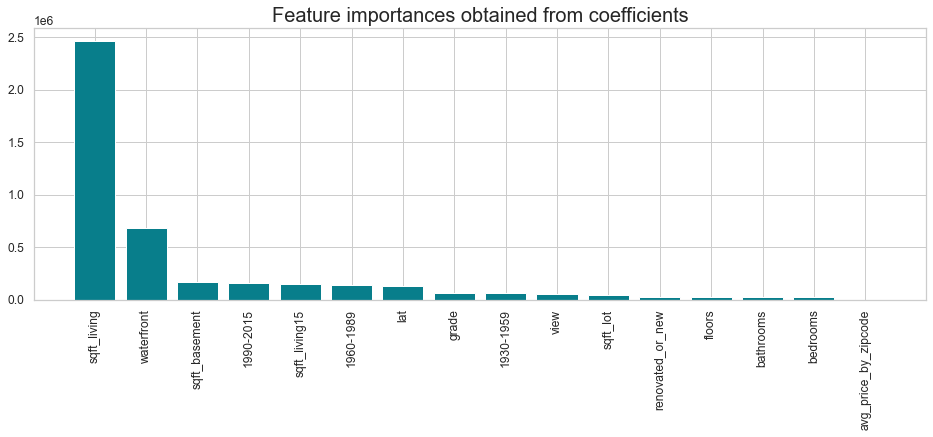

In [42]:
features_importance = pd.DataFrame(data={
    'Attribute': X_train_ready.columns,
    'Importance': abs(model.coef_)
})
features_importance = features_importance.sort_values(by='Importance', ascending=False)

fig, axe = plt.subplots(figsize = (16,5))
sns.set(font_scale=1.1) # Font size

plt.bar(x=features_importance['Attribute'], height=features_importance['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [43]:
features_importance.head(17)

,Attribute,Importance
0,sqft_living,2.463832e+06
10,waterfront,6.887600e+05
1,sqft_basement,1.675116e+05
6,1990-2015,1.652409e+05
3,sqft_living15,1.530491e+05
5,1960-1989,1.400854e+05
14,lat,1.320679e+05
12,grade,6.679019e+04
4,1930-1959,6.136920e+04
11,view,5.654561e+04


C:\Users\atycn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\atycn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residuals by predicted')

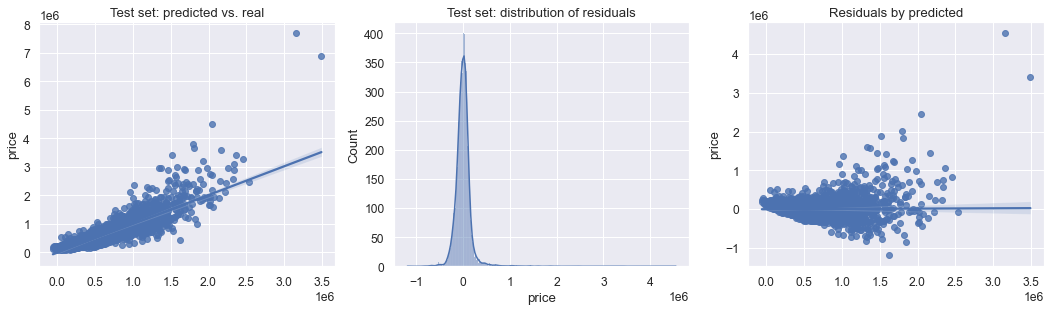

In [44]:
fig, ax = plt.subplots(1,3, figsize = (18,4.5))

sns.regplot(y_pred, y_test, 'o', ax=ax[0]).set_title("Test set: predicted vs. real")
sns.histplot(y_test - y_pred, kde=True, ax=ax[1]).set_title("Test set: distribution of residuals")
sns.regplot(y_pred,y_test - y_pred,"o", ax=ax[2]).set_title("Residuals by predicted")
